In [49]:
# Instalar librerías si no están

!pip install pandas numpy matplotlib seaborn --quiet

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Cargamos dataset exportado desde MySQL

df = pd.read_csv('customer_activity_clean.csv')


In [51]:
# Cambiamos las fechas a "datetime"

df['first_rental'] = pd.to_datetime(df['first_rental'])
df['last_rental'] = pd.to_datetime(df['last_rental'])


In [52]:
# Verificar duplicados

print("Duplicados totales:", df.duplicated().sum())
df = df.drop_duplicates()  # Eliminamos duplicados exactos


Duplicados totales: 0


In [53]:
# Vemos que valores faltan

print(df.isnull().sum())

customer_id            0
first_name             0
last_name              0
email                  0
active                 0
address                0
district               3
postal_code            0
city                   0
country                0
total_rentals          0
total_payments         0
first_rental           0
last_rental            0
avg_rental_duration    0
dtype: int64


In [54]:
# Normalizamos las cadenas

cols_text = ['first_name', 'last_name', 'email', 'address', 'district', 'city', 'country']
for col in cols_text:
    df[col] = df[col].str.lower().str.strip()

In [55]:
# Corregimos los tipos numéricos

df['total_rentals'] = pd.to_numeric(df['total_rentals'], errors='coerce')
df['total_payments'] = pd.to_numeric(df['total_payments'], errors='coerce')
df['active'] = df['active'].astype(int)
df['postal_code'] = df['postal_code'].astype(str)


In [56]:
# Detectamos outliers en total_payments

Q1 = df['total_payments'].quantile(0.25)
Q3 = df['total_payments'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['total_payments'] < Q1 - 1.5*IQR) | (df['total_payments'] > Q3 + 1.5*IQR)]

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print("Outliers detectados:")
print(outliers[['customer_id', 'total_payments']])


Q1: 93.78, Q3: 127.71, IQR: 33.92999999999999
Outliers detectados:
     customer_id  total_payments
136          137          194.61
143          144          195.58
147          148          216.54
177          178          189.62
458          459          186.62
525          526          221.55


In [57]:
# Creamos columnas derivadas

df['rental_span_days'] = (df['last_rental'] - df['first_rental']).dt.days
df['avg_payment_per_rental'] = df['total_payments'] / df['total_rentals']
cols = ['first_name', 'last_name', 'avg_payment_per_rental']
df[cols]

,first_name,last_name,avg_payment_per_rental
0,mary,smith,3.708750
1,patricia,johnson,4.767778
2,linda,williams,5.220769
3,barbara,jones,3.717273
4,elizabeth,brown,3.881892
...,...,...,...
594,terrence,gunderson,3.923333
595,enrique,forsythe,3.545556
596,freddie,duggan,3.948333
597,wade,delvalle,3.808182


In [58]:
# Grafica de clientes por pais
clients_by_country = df.groupby('country')['customer_id'].nunique().reset_index()
clients_by_country.rename(columns={'customer_id':'num_clients'}, inplace=True)

fig = px.choropleth(
    clients_by_country,
    locations='country',
    locationmode='country names',
    color='num_clients',
    color_continuous_scale='RdYlGn',
    title='Cantidad de clientes por país'
)

fig.show()

In [59]:
# Grafica con media de alquiler pos pais

avg_rentals_country = (
    df.groupby('country')['total_rentals']
      .mean()
      .reset_index()
)

avg_rentals_country.rename(
    columns={'total_rentals': 'avg_rentals'},
    inplace=True
)

fig = px.choropleth(
    avg_rentals_country,
    locations='country',
    locationmode='country names',
    color='avg_rentals',
    color_continuous_scale='RdYlGn',
    title='Media de rentas por país'
)

fig.show()


/tmp/ipython-input-1585342985.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




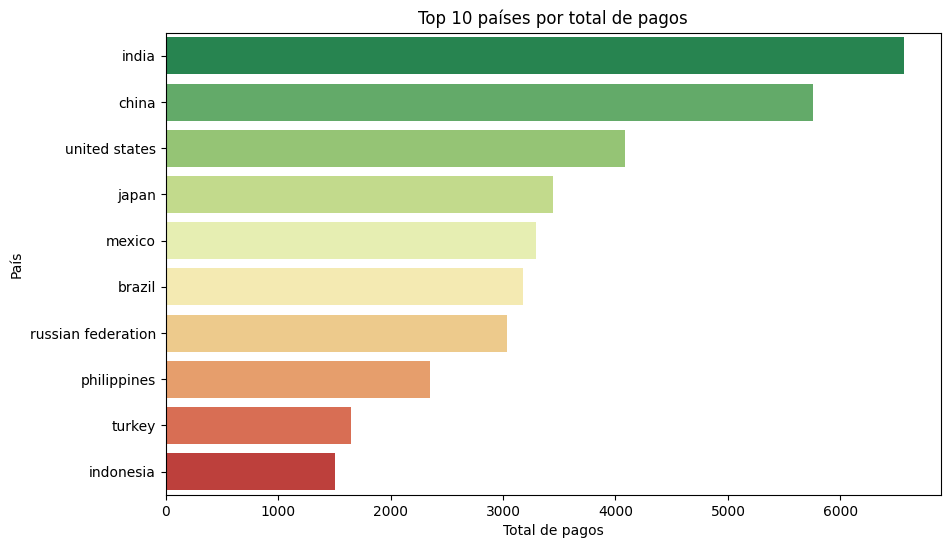

In [60]:
# Top 10 paises que mas han pagado

top10_payments = df.groupby('country')['total_payments']\
                   .sum()\
                   .sort_values(ascending=False)\
                   .head(10)\
                   .reset_index()


plt.figure(figsize=(10,6))
sns.barplot(x='total_payments', y='country', data=top10_payments, palette='RdYlGn_r')
plt.title('Top 10 países por total de pagos')
plt.xlabel('Total de pagos')
plt.ylabel('País')
plt.show()
